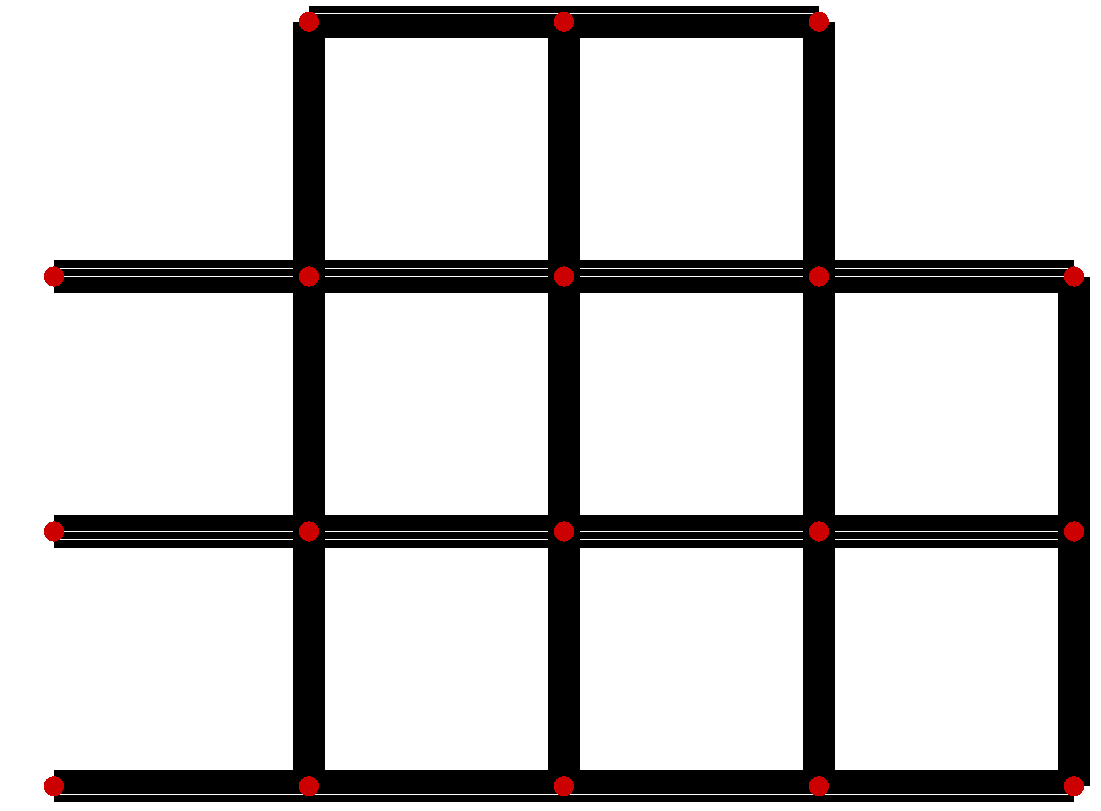

Epoch 1/10
788/788 [==============================] - 13s 12ms/step - loss: 0.0053 - val_loss: 2.1254e-04
Epoch 2/10
788/788 [==============================] - 8s 10ms/step - loss: 1.6289e-04 - val_loss: 1.2813e-04
Epoch 3/10
788/788 [==============================] - 8s 10ms/step - loss: 1.1193e-04 - val_loss: 1.3484e-04
Epoch 4/10
788/788 [==============================] - 9s 11ms/step - loss: 8.2533e-05 - val_loss: 7.5577e-05
Epoch 5/10
788/788 [==============================] - 9s 11ms/step - loss: 6.0346e-05 - val_loss: 1.2547e-04
Epoch 6/10
788/788 [==============================] - 9s 11ms/step - loss: 4.3941e-05 - val_loss: 3.9660e-05
Epoch 7/10
788/788 [==============================] - 9s 12ms/step - loss: 2.9474e-05 - val_loss: 2.7188e-05
Epoch 8/10
788/788 [==============================] - 7s 9ms/step - loss: 2.5553e-05 - val_loss: 2.4649e-05
Epoch 9/10
788/788 [==============================] - 9s 11ms/step - loss: 2.1508e-05 - val_loss: 5.7044e-05
Epoch 10/10
394/394 [==

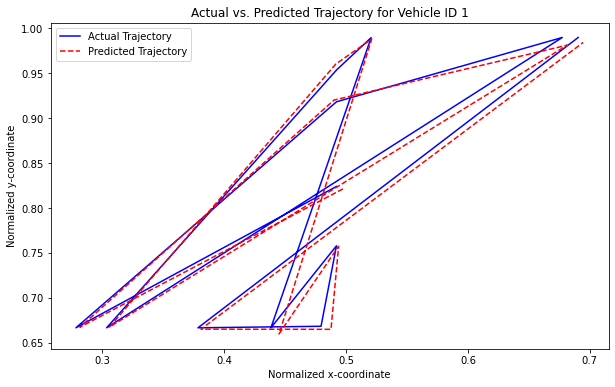

In [1]:

# SEQUENTIAL PROCESSING -- LSTM
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Load and preprocess data
file_path = 'extended_fcd_output.csv'
df = pd.read_csv(file_path)
scaler = MinMaxScaler(feature_range=(0, 1))
df[['x', 'y', 'speed', 'acceleration', 'angle', 'time']] = scaler.fit_transform(df[['x', 'y', 'speed', 'acceleration', 'angle', 'time']])

# Create sequences for LSTM
timesteps = 5
X, y, vehicle_ids = [], [], []
for vehicle_id in df['id'].unique():
    vehicle_df = df[df['id'] == vehicle_id]
    for i in range(len(vehicle_df) - timesteps):
        X.append(vehicle_df.iloc[i:i+timesteps][['x', 'y', 'speed', 'acceleration', 'angle', 'time']].values)
        y.append(vehicle_df.iloc[i + timesteps][['x', 'y']].values)
        vehicle_ids.append(vehicle_id)

X, y, vehicle_ids = np.array(X), np.array(y), np.array(vehicle_ids)


# Convert the lists to numpy arrays and ensure the type is float32
X = np.array(X, dtype='float32')
y = np.array(y, dtype='float32')
vehicle_ids = np.array(vehicle_ids, dtype='float32') # If needed, convert vehicle IDs too

# Split data into training and testing sets
X_train, X_test, y_train, y_test, vehicle_ids_train, vehicle_ids_test = train_test_split(X, y, vehicle_ids, test_size=0.2, random_state=42)


# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(2))  # Predicting 'x' and 'y' coordinates

# Compile and train the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

# Make predictions
y_pred = model.predict(X_test)

# Plot actual vs. predicted trajectories for a specific vehicle ID
vehicle_id_to_plot = 1  # Replace with the vehicle ID you want to analyze
indices_to_plot = vehicle_ids_test == vehicle_id_to_plot
actual_trajectories = y_test[indices_to_plot]
predicted_trajectories = y_pred[indices_to_plot]

plt.figure(figsize=(10, 6))
plt.plot(actual_trajectories[:, 0], actual_trajectories[:, 1], label='Actual Trajectory', color='blue')
plt.plot(predicted_trajectories[:, 0], predicted_trajectories[:, 1], label='Predicted Trajectory', color='red', linestyle='dashed')
plt.title(f'Actual vs. Predicted Trajectory for Vehicle ID {vehicle_id_to_plot}')
plt.xlabel('Normalized x-coordinate')
plt.ylabel('Normalized y-coordinate')
plt.legend()
plt.show()

##### Combine GNN

In [79]:
from sklearn.metrics import mean_squared_error
from math import sqrt


# Calculate Euclidean distances for all predictions
distances = np.sqrt(np.sum((y_test - y_pred)**2, axis=1))

# Decide on your percentile for the threshold
percentile = 90
threshold_distance = np.percentile(distances, percentile)

print(f"The {percentile}th percentile distance threshold is: {threshold_distance} units.")

# Define a function to calculate the distance
def calculate_distance(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# Define the threshold distance for a correct prediction (this is an arbitrary example value)
# threshold_distance = 0.01  # This would depend on the scale of your coordinate system

# Calculate the distances for all predictions
distances = np.array([calculate_distance(y_test[i], y_pred[i]) for i in range(len(y_test))])

# Determine which predictions are within the threshold
correct_predictions = distances < threshold_distance

# Calculate the percentage of correct predictions
percentage_correct = (correct_predictions.sum() / len(correct_predictions)) * 100

print(f"Percentage of the journey where ML can predict the final destination within {threshold_distance} units: {percentage_correct}%")


The 90th percentile distance threshold is: 0.007446835190057756 units.
Percentage of the journey where ML can predict the final destination within 0.007446835190057756 units: 95.36323938070663%


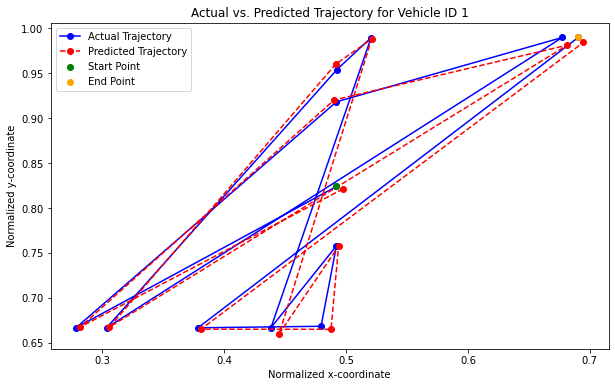

In [73]:
# Plot actual vs. predicted trajectories for a specific vehicle ID
vehicle_id_to_plot = 1  # Replace with the vehicle ID you want to analyze
indices_to_plot = vehicle_ids_test == vehicle_id_to_plot
actual_trajectories = y_test[indices_to_plot]
predicted_trajectories = y_pred[indices_to_plot]

plt.figure(figsize=(10, 6))
plt.plot(actual_trajectories[:, 0], actual_trajectories[:, 1], 'o-', label='Actual Trajectory', color='blue')
plt.plot(predicted_trajectories[:, 0], predicted_trajectories[:, 1], 'o--', label='Predicted Trajectory', color='red')
#plt.gca().set_aspect('equal', adjustable='box')  # This ensures that the scale is the same on both axes

# Marking the starting and ending points
plt.scatter(actual_trajectories[0, 0], actual_trajectories[0, 1], color='green', label='Start Point', zorder=5)
plt.scatter(actual_trajectories[-1, 0], actual_trajectories[-1, 1], color='orange', label='End Point', zorder=5)

plt.title(f'Actual vs. Predicted Trajectory for Vehicle ID {vehicle_id_to_plot}')
plt.xlabel('Normalized x-coordinate')
plt.ylabel('Normalized y-coordinate')
plt.legend()
plt.show()

In [ ]:

# Assuming 'x_values' and 'y_values' are lists or arrays of your Cartesian coordinates
x_values = df['x']
y_values = df['y']

plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values, 'o-', label='Trajectory')  # 'o-' will create a line plot with circle markers
plt.gca().set_aspect('equal', adjustable='box')  # This ensures that the scale is the same on both axes
plt.title('Trajectory Plot')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.grid(True)
plt.show()

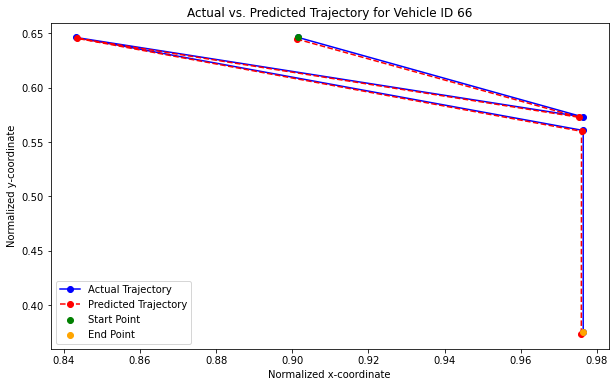

In [58]:
# Plot actual vs. predicted trajectories for a specific vehicle ID
vehicle_id_to_plot = 66  # Replace with the vehicle ID you want to analyze
indices_to_plot = vehicle_ids_test == vehicle_id_to_plot
actual_trajectories = y_test[indices_to_plot]
predicted_trajectories = y_pred[indices_to_plot]

plt.figure(figsize=(10, 6))
plt.plot(actual_trajectories[:, 0], actual_trajectories[:, 1], 'o-', label='Actual Trajectory', color='blue')
plt.plot(predicted_trajectories[:, 0], predicted_trajectories[:, 1], 'o--', label='Predicted Trajectory', color='red')

# Marking the starting and ending points
plt.scatter(actual_trajectories[0, 0], actual_trajectories[0, 1], color='green', label='Start Point', zorder=5)
plt.scatter(actual_trajectories[-1, 0], actual_trajectories[-1, 1], color='orange', label='End Point', zorder=5)

plt.title(f'Actual vs. Predicted Trajectory for Vehicle ID {vehicle_id_to_plot}')
plt.xlabel('Normalized x-coordinate')
plt.ylabel('Normalized y-coordinate')
plt.legend()
plt.show()

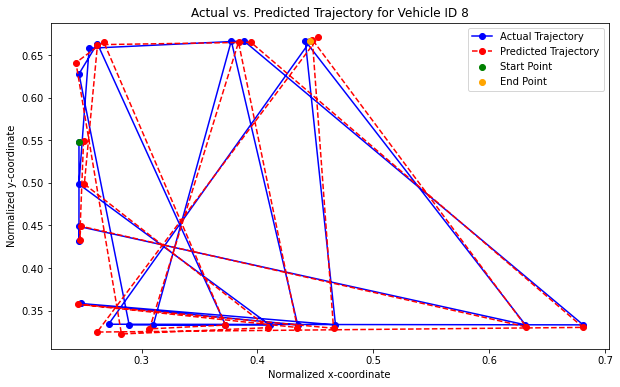

In [69]:
# Plot actual vs. predicted trajectories for a specific vehicle ID
vehicle_id_to_plot = 8  # Replace with the vehicle ID you want to analyze
indices_to_plot = vehicle_ids_test == vehicle_id_to_plot
actual_trajectories = y_test[indices_to_plot]
predicted_trajectories = y_pred[indices_to_plot]

plt.figure(figsize=(10, 6))
plt.plot(actual_trajectories[:, 0], actual_trajectories[:, 1], 'o-', label='Actual Trajectory', color='blue')
plt.plot(predicted_trajectories[:, 0], predicted_trajectories[:, 1], 'o--', label='Predicted Trajectory', color='red')

# Marking the starting and ending points
plt.scatter(actual_trajectories[0, 0], actual_trajectories[0, 1], color='green', label='Start Point', zorder=5)
plt.scatter(actual_trajectories[-1, 0], actual_trajectories[-1, 1], color='orange', label='End Point', zorder=5)

plt.title(f'Actual vs. Predicted Trajectory for Vehicle ID {vehicle_id_to_plot}')
plt.xlabel('Normalized x-coordinate')
plt.ylabel('Normalized y-coordinate')
plt.legend()
plt.show()

In [4]:


# Assume y_true are the true values and y_pred are the model's predictions
# y_true is [actual values]
# y_pred is [model's predictions]

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Here y_test are the true values and y_pred are the model's predictions
# These should be obtained from your actual model's predictions

# Calculate MSE, RMSE, and MAE
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

# Print the results
print(f"MSE: {mse}, RMSE: {rmse}, MAE: {mae}")


MSE: 1.2109262570447754e-05, RMSE: 0.0034790111239999533, MAE: 0.0023079058155417442


In [5]:
import xml.etree.ElementTree as ET

# Load and parse the .net.xml file
tree = ET.parse('NETWORK.net.xml')
root = tree.getroot()

# Initialize lists to store the extracted data
edges = []
junctions = []
lanes = []
connections = []
roundabouts = []
traffic_lights = []
location_info = {}

# Extract edges
for edge in root.findall('edge'):
    edge_id = edge.get('id')
    edge_from = edge.get('from')
    edge_to = edge.get('to')
    edge_priority = edge.get('priority')
    edge_type = edge.get('type')
    edges.append({
        'id': edge_id,
        'from': edge_from,
        'to': edge_to,
        'priority': edge_priority,
        'type': edge_type
    })

# Extract junctions
for junction in root.findall('junction'):
    junction_id = junction.get('id')
    x, y = junction.get('x'), junction.get('y')
    junction_shape = junction.get('shape')
    junctions.append({
        'id': junction_id,
        'x': x,
        'y': y,
        'shape': junction_shape
    })

# Extract lanes (within edges)
for edge in root.findall('edge'):
    for lane in edge.findall('lane'):
        lane_id = lane.get('id')
        lane_index = lane.get('index')
        lane_speed = lane.get('speed')
        lane_length = lane.get('length')
        lane_shape = lane.get('shape')
        lanes.append({
            'id': lane_id,
            'index': lane_index,
            'speed': lane_speed,
            'length': lane_length,
            'shape': lane_shape
        })

# Extract connections
for connection in root.findall('connection'):
    connection_from = connection.get('from')
    connection_to = connection.get('to')
    connection_fromLane = connection.get('fromLane')
    connection_toLane = connection.get('toLane')
    connections.append({
        'from': connection_from,
        'to': connection_to,
        'fromLane': connection_fromLane,
        'toLane': connection_toLane
    })

# Extract roundabouts
for roundabout in root.findall('roundabout'):
    roundabout_edges = roundabout.get('edges').split()
    roundabouts.append({'edges': roundabout_edges})

# Extract traffic light logic
for tlLogic in root.findall('tlLogic'):
    tl_id = tlLogic.get('id')
    tl_program_id = tlLogic.get('programID')
    tl_phases = [{'duration': phase.get('duration'), 'state': phase.get('state')}
                 for phase in tlLogic.findall('phase')]
    traffic_lights.append({
        'id': tl_id,
        'program_id': tl_program_id,
        'phases': tl_phases
    })

# Extract location
location = root.find('location')
location_info = {
    'net_offset': location.get('netOffset'),
    'conv_boundary': location.get('convBoundary'),
    'orig_boundary': location.get('origBoundary'),
    'proj_parameter': location.get('projParameter')
}

# Now you have dictionaries filled with the extracted data
# You can further process these or save them as needed


In [6]:
import networkx as nx

# Assuming 'edges', 'junctions', and 'connections' are already extracted from the .net.xml file

# Create a directed graph
G = nx.DiGraph()

# Add junctions to the graph as nodes
for junction in junctions:
    G.add_node(junction['id'], pos=(junction['x'], junction['y']))

# Add edges to the graph with a check for NO None values
for edge in edges:
    if edge['from'] is not None and edge['to'] is not None:  # Check for None values
        G.add_edge(edge['from'], edge['to'], id=edge['id'])

        # Optionally, add lanes as attributes to the edge
        edge_lanes = [lane for lane in lanes if lane['id'].startswith(edge['id'] + '_')]
        if edge_lanes:  # Check if there are lanes for the edge
            G.edges[edge['from'], edge['to']]['lanes'] = edge_lanes

# Add connections as edges
for connection in connections:
    # Use the correct attribute names from your connection data
    from_lane_id = connection['fromLane']  # Adjust this key if necessary
    to_lane_id = connection['toLane']      # Adjust this key if necessary
    
    # Extract edge IDs from lane IDs if they contain them
    from_edge_id = from_lane_id.rsplit('_', 1)[0] if '_' in from_lane_id else from_lane_id
    to_edge_id = to_lane_id.rsplit('_', 1)[0] if '_' in to_lane_id else to_lane_id
    
    # Add edge if it's not already in the graph
    if not G.has_edge(from_edge_id, to_edge_id):
        G.add_edge(from_edge_id, to_edge_id)

    # Now, add the connection details as attributes to the edge
    G.edges[from_edge_id, to_edge_id]['connection'] = connection

    
# Add lanes to edges
for lane in lanes:
    edge_id = lane['id'].rsplit('_', 1)[0]
    if 'from' in lane:  # Incoming lanes
        G.nodes[lane['from']].setdefault('incoming_lanes', []).append(lane)
    if 'to' in lane:  # Outgoing lanes
        G.nodes[lane['to']].setdefault('outgoing_lanes', []).append(lane)

# Now G is a NetworkX graph that represents the road network

In [7]:
###FEATURE ENGINEERING

# Node feature engineering example:
for node_id in G.nodes:
    # Example of adding traffic light status - You need the actual status from SUMO or your data
    G.nodes[node_id]['traffic_light'] = 'green'  # replace this with actual data retrieval logic
    
    # Example of counting incoming/outgoing lanes:
    G.nodes[node_id]['incoming_lanes_count'] = len(G.nodes[node_id].get('incoming_lanes', []))
    G.nodes[node_id]['outgoing_lanes_count'] = len(G.nodes[node_id].get('outgoing_lanes', []))

# Edge feature engineering example:
for edge in G.edges:
    # Example of adding road length, number of lanes, and maximum speed - You need actual data from SUMO
    G.edges[edge]['length'] = 100  # replace with actual length
    G.edges[edge]['num_lanes'] = 2  # replace with actual lane count
    G.edges[edge]['max_speed'] = 50.0  # replace with actual speed limit

### SNAPSHOT METHOD
start_time = 0  # Starting time step of your simulation
end_time = 100  # Ending time step of your simulation
time_step_interval = 1  # Interval between time steps

snapshots = []
for time_step in range(start_time, end_time, time_step_interval):
    # Create a snapshot of the graph
    snapshot = G.copy()
    
    # Update dynamic features for the snapshot
    for edge in snapshot.edges:
        # Example of updating vehicle count and average speed - You need actual data from SUMO
        snapshot.edges[edge]['vehicle_count'] = 10  # replace with actual vehicle count
        snapshot.edges[edge]['average_speed'] = 25.0  # replace with actual average speed
    
    snapshots.append(snapshot)
# Note: For real-time simulation data, you would extract information using TraCI in a loop over each time step.


Graph Convolutional Network (GCN)

GCNs are well-suited for semi-supervised learning on graph-structured data. They can capture the spatial structure of the road network and are good for tasks where the influence of a road segment or intersection extends to its immediate neighbors.
To predict traffic conditions by learning from the structure of the road network and traffic patterns on it.

Spatial-Temporal Graph Convolutional Networks (ST-GCN):

ST-GCNs are specifically designed to handle spatial-temporal data, which is a natural fit for traffic data that varies both in space (across different road segments) and time.
To predict future vehicle trajectories or traffic conditions by learning from both spatial dependencies and temporal dynamics.


In [71]:
def find_closest_node(point, G):
    min_distance = float('inf')
    closest_node = None
    x, y = point  # Ensure x, y are floats

    for node_id, node_data in G.nodes(data=True):
        node_pos = node_data['pos']
        # Convert node positions to float if they are not already
        node_x, node_y = map(float, node_pos)  # Ensure both values are floats

        # Calculate Euclidean distance
        distance = ((node_x - x)**2 + (node_y - y)**2)**0.5
        if distance < min_distance:
            min_distance = distance
            closest_node = node_id

    return closest_node

def map_vehicle_to_nodes(vehicle_trajectory, G):
    node_indices = []
    for point in vehicle_trajectory:
        # Ensure x, y are floats
        x, y = float(point[1]), float(point[2])  # Convert x, y to floats
        node_index = find_closest_node((x, y), G)
        node_indices.append(node_index)
    return node_indices

# Assuming X_train, X_val, X_test are your LSTM datasets (vehicle trajectories)
train_node_indices = [map_vehicle_to_nodes(trajectory, G) for trajectory in X_train]
val_node_indices = [map_vehicle_to_nodes(trajectory, G) for trajectory in X_val]
test_node_indices = [map_vehicle_to_nodes(trajectory, G) for trajectory in X_test]

# Prepare GCN features (X_gcn) based on the node features in G
# X_gcn should be an array where each row corresponds to node features
# Assuming you have defined X_gcn based on the features of nodes in G
X_gcn_train = [X_gcn[indices] for indices in train_node_indices]
X_gcn_val = [X_gcn[indices] for indices in val_node_indices]
X_gcn_test = [X_gcn[indices] for indices in test_node_indices]



KeyError: 'pos'

In [50]:
for node_id, node_data in your_node_data.items():  # Replace 'your_node_data' with your actual node data source
    x, y = calculate_position(node_data)  # Replace with your method of calculating position
    G.add_node(node_id, pos=(x, y))

def find_closest_node(point, G):
    min_distance = float('inf')
    closest_node = None
    x, y = point

    for node in G.nodes(data=True):
        # Convert node positions to float if they are not already
        node_x, node_y = map(float, node[1]['pos'])  # Convert node position to float

        # Calculate Euclidean distance
        distance = ((node_x - x)**2 + (node_y - y)**2)**0.5
        if distance < min_distance:
            min_distance = distance
            closest_node = node[0]

    return closest_node

def map_vehicle_to_nodes(vehicle_trajectory, G):
    node_indices = []
    for point in vehicle_trajectory:
        # Assuming each 'point' is an array with format [time, x, y, speed, acceleration, angle]
        # Extract x and y coordinates
        x, y = point[1], point[2]  # Adjust indices if necessary based on your data format
        node_index = find_closest_node((x, y), G)
        node_indices.append(node_index)
    return node_indices

# Assuming X_train, X_val, X_test are your LSTM datasets (vehicle trajectories)
train_node_indices = [map_vehicle_to_nodes(trajectory, G) for trajectory in X_train]
val_node_indices = [map_vehicle_to_nodes(trajectory, G) for trajectory in X_val]
test_node_indices = [map_vehicle_to_nodes(trajectory, G) for trajectory in X_test]

# Now use these indices to extract relevant node features for GCN
X_gcn_train = [X_gcn[indices] for indices in train_node_indices]
X_gcn_val = [X_gcn[indices] for indices in val_node_indices]
X_gcn_test = [X_gcn[indices] for indices in test_node_indices]

NameError: name 'your_node_data' is not defined

In [41]:


# Assuming G is your NetworkX graph and X_lstm is your LSTM input with shape (num_samples, timesteps, features)
# The adjacency matrix 'A' should be in sparse format and the node features 'X_gcn' should be in dense format.

#import numpy as np
import networkx as nx
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate
from tensorflow.keras.models import Model
import spektral
from spektral.layers import GCNConv
from scipy.sparse import coo_matrix


# Assuming 'G' is your NetworkX graph and 'X_lstm' is your LSTM input with shape (num_samples, timesteps, features)
# Features in GCN : Road length, Number of lanes, Maximum speed

# Convert adjacency matrix to numpy array and then to a TensorFlow tensor
A_numpy = nx.to_numpy_array(G, dtype=np.float32)  # Convert to numpy array
A_tensor = tf.convert_to_tensor(A_numpy)  # Convert numpy array to TensorFlow tensor

shape  = 3 #3 features
# Define feature matrix 'X_gcn' for GCN
# Ensure that each node in your graph 'G' has a 'feature_vector' attribute
X_gcn = np.array([G.nodes[node].get('feature_vector', np.zeros(shape)) for node in G.nodes], dtype='float32')
# Note: Replace 'shape' with the shape of your feature vector, e.g., (number_of_features,)

# The LSTM part

# Assuming X is already defined and preprocessed from the previous LSTM code
X_lstm = X.reshape((-1, timesteps, 6))  # Reshape X to have the shape (num_samples, timesteps, features)
X_lstm = X_lstm.astype('float32')  # Ensure the data type is float32 for compatibility with TensorFlow

# Assuming X_lstm is already defined and preprocessed
lstm_input = Input(shape=(X_lstm.shape[1], X_lstm.shape[2]))  # Adjust the shape according to your LSTM input
lstm_output = LSTM(units=50, return_sequences=True)(lstm_input)
lstm_output = LSTM(units=50)(lstm_output)

# The GCN part
gcn_input = Input(shape=(X_gcn.shape[1],))
# Convert adjacency matrix to numpy array and then to a TensorFlow tensor
A_numpy = nx.to_numpy_array(G, dtype=np.float32)  # Convert to numpy array
A_tensor = tf.convert_to_tensor(A_numpy)  # Convert numpy array to TensorFlow tensor


gcn_output = GCNConv(32, activation='relu')([gcn_input, A_tensor])
gcn_output = GCNConv(32, activation='relu')([gcn_output, A_tensor])

# Combining LSTM and GCN outputs
combined = Concatenate()([lstm_output, gcn_output])
final_output = Dense(2)(combined)  # Predicting 'x' and 'y' coordinates

# Create the model
model = Model(inputs=[lstm_input, gcn_input, A_tensor], outputs=final_output)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Evaluate the model
# Your evaluation code here...
# ...

# Note: This code does not handle dynamic graphs out-of-the-box. You would need to update A and X_gcn at each time step
# if you are working with a dynamic graph that changes over time (such as in a traffic network simulation).


ValueError: Found unexpected instance while processing input tensors for keras functional model. Expecting KerasTensor which is from tf.keras.Input() or output from keras layer call(). Got: [[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 1. 1.]]

In [45]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate
from tensorflow.keras.models import Model
from spektral.layers import GCNConv

# ... [your code for loading the data] ...

# Define the LSTM input layer
lstm_input = Input(shape=(X_lstm.shape[1], X_lstm.shape[2]), name='lstm_input')
# Define the LSTM layers
lstm_output = LSTM(units=50, return_sequences=True)(lstm_input)
lstm_output = LSTM(units=50)(lstm_output)

# Define the GCN input layer
gcn_input = Input(shape=(X_gcn.shape[1],), name='gcn_input')
# Convert the adjacency matrix to a tensor for Spektral compatibility
# We do not use 'A_tensor' as an input to the model directly, it's used as a supporting input
import tensorflow as tf
from scipy.sparse import coo_matrix

# Assuming 'A_sparse' is your Scipy sparse adjacency matrix in COO format
A_sparse = coo_matrix(A_numpy)

# Create a SparseTensor from A_sparse
A_indices = np.column_stack((A_sparse.row, A_sparse.col))
A_values = A_sparse.data
A_dense_shape = A_sparse.shape

A_tensor = tf.SparseTensor(A_indices, A_values, A_dense_shape)
A_tensor = tf.cast(A_tensor, dtype=tf.float32)  # Ensure the data type is float32


# Define the GCN layers
gcn_output = GCNConv(32, activation='relu')([gcn_input, A_tensor])
gcn_output = GCNConv(32, activation='relu')([gcn_output, A_tensor])

# Combining LSTM and GCN outputs
combined = Concatenate()([lstm_output, gcn_output])
final_output = Dense(2)(combined)  # Predicting 'x' and 'y' coordinates

# Create the model. Notice that we do not include 'A_tensor' in the inputs list.
model = Model(inputs=[lstm_input, gcn_input], outputs=final_output)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Prepare your training data: X_lstm_train, X_gcn_train, y_train
# Prepare your validation data: X_lstm_val, X_gcn_val, y_val

# ... [previous code for combined LSTM and GCN model] ...

# Fit the combined model
# X_gcn_train, X_gcn_val, and X_gcn_test need to be prepared for GCN part
model.fit([X_train, X_gcn_train], y_train, epochs=10, batch_size=64,
          validation_data=([X_test, X_gcn_val], y_test))

# Make predictions using the combined model
gcn_pred = model.predict([X_test, X_gcn_test])


NameError: name 'X_gcn_train' is not defined